In [603]:
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import numpy as np
import os
from keras import backend as K
from keras.utils import image_utils
import matplotlib.pyplot as plt
from keras.applications import vgg19
from keras.models import Model
#from keras import optimizers
from scipy.optimize import fmin_l_bfgs_b
#from keras.applications.vgg19 import VGG19
#vgg19_weights = '../input/vgg19/vgg19_weights_tf_dim_ordering_tf_kernels_notop.h5'
#vgg19 = VGG19(include_top = False, weights=vgg19_weights)
print(os.listdir("./input/"))
# Any results you write to the current directory are saved as output.

['111 copy.jpeg', 'k.jpeg', 'r.jpeg', 'i.png', 'g.jpeg', 'f.jpeg', '.DS_Store', 'Claude_Monet_1.jpg', 'j.jpeg', '11.jpeg', 'm.jpeg', 'l.jpeg', 'c.jpeg', '22.jpeg', 'o.jpeg', '55.jpeg', 'n.jpeg', 'b.jpeg', '4.jpg', '5.jpg', '7.jpg', 'e.jpeg', 'a.png', 'El_Greco_1.jpg', '6.png', 'p.jpeg', '111.jpeg', '2.jpg', 'd.png', 's.png', '33.jpeg', '3.jpg', '44.jpeg', 'h.jpeg', 'q.png']


In [604]:
StylePath = './input/'
ContentPath = './input/'

In [966]:
style_image_path = StylePath+'n.jpeg'
base_image_path = ContentPath+'111.jpeg'

In [967]:
# dimensions of the generated picture.
width, height = image_utils.load_img(base_image_path).size
img_nrows = 400
img_ncols = int(width * img_nrows / height)

In [968]:
def preprocess_image(image_path):
    from keras.applications import vgg19
    img = image_utils.load_img(image_path, target_size=(img_nrows, img_ncols))
    img = image_utils.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = vgg19.preprocess_input(img)
    return img

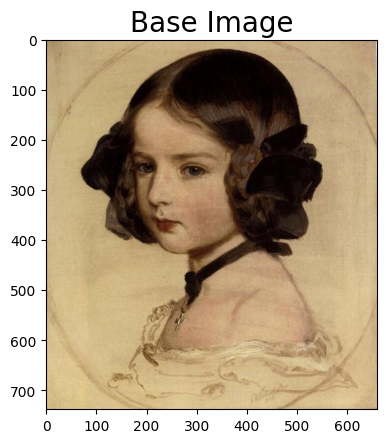

In [969]:
plt.figure()
plt.title("Base Image",fontsize=20)
img1 = image_utils.load_img(base_image_path)
plt.imshow(img1)

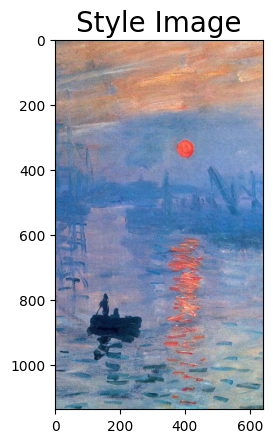

In [970]:
plt.figure()
plt.title("Style Image",fontsize=20)
img1 = image_utils.load_img(style_image_path)
plt.imshow(img1)

In [971]:
# get tensor representations of our images

base_image = K.variable(preprocess_image(base_image_path))
style_reference_image = K.variable(preprocess_image(style_image_path))

In [972]:
K.image_data_format()

'channels_last'

In [973]:
# this will contain our generated image
if K.image_data_format() == 'channels_first':
    combination_image = K.placeholder((1,3,img_nrows, img_ncols))
else:
    combination_image = K.placeholder((1,img_nrows, img_ncols,3))

In [974]:


# combine the 3 images into a single Keras tensor
input_tensor = K.concatenate([base_image,
                              style_reference_image,
                              combination_image
                              ], axis=0)


In [975]:
# build the VGG19 network with our 3 images as input
# the model will be loaded with pre-trained ImageNet weights
from keras.applications.vgg19 import VGG19
vgg19_weights = './vgg19_weights_tf_dim_ordering_tf_kernels_notop.h5'
model = VGG19(input_tensor=input_tensor,
              include_top = False,
              weights=vgg19_weights)
#model = vgg19.VGG19(input_tensor=input_tensor,
#                    weights='imagenet', include_top=False)
print('Model loaded.')

2023-03-17 10:33:42.497729: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-03-17 10:33:42.558259: W tensorflow/c/c_api.cc:291] Operation '{name:'Variable_97/Assign' id:32724 op device:{requested: '', assigned: ''} def:{{{node Variable_97/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](Variable_97, Variable_97/Initializer/initial_value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-03-17 10:33:42.938224: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Model loaded.


2023-03-17 10:33:43.322146: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


In [976]:
# Content layer where will pull our feature maps
content_layers = ['block5_conv2'] 

# Style layer we are interested in
style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1', 
                'block4_conv1',
                'block5_conv1'
               ]

num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

In [977]:
outputs_dict = dict([(layer.name, layer.output) for layer in model.layers])
print(outputs_dict['block5_conv2'])

Tensor("block5_conv2_32/Relu:0", shape=(3, 25, 22, 512), dtype=float32)


In [978]:
# an auxiliary loss function
# designed to maintain the "content" of the
# base image in the generated image
def get_content_loss(base_content, target):
    return K.sum(K.square(target - base_content))

In [979]:
import tensorflow as tf
# the gram matrix of an image tensor (feature-wise outer product)
def gram_matrix(input_tensor):
    assert K.ndim(input_tensor)==3
    #if K.image_data_format() == 'channels_first':
    #    features = K.batch_flatten(input_tensor)
    #else:
    #    features = K.batch_flatten(K.permute_dimensions(input_tensor,(2,0,1)))
    #gram = K.dot(features, K.transpose(features))
    channels = int(input_tensor.shape[-1])
    a = tf.reshape(input_tensor, [-1, channels])
    n = tf.shape(a)[0]
    gram = tf.matmul(a, a, transpose_a=True)
    return gram#/tf.cast(n, tf.float32)

def get_style_loss(style, combination):
    assert K.ndim(style) == 3
    assert K.ndim(combination) == 3
    S = gram_matrix(style)
    C = gram_matrix(combination)
    channels = 3
    size = img_nrows*img_ncols
    return K.sum(K.square(S - C))#/(4.0 * (channels ** 2) * (size ** 2))


In [980]:
content_weight=0.025 
style_weight=1.0
# combine these loss functions into a single scalar
loss = K.variable(0.0)
layer_features = outputs_dict['block5_conv2']
base_image_features = layer_features[0, :, :, :]
combination_features = layer_features[2, :, :, :]
print('Layer Feature for Content Layers :: '+str(layer_features))
print('Base Image Feature :: '+str(base_image_features))
print('Combination Image Feature for Content Layers:: '+str(combination_features)+'\n')
loss = loss + content_weight * get_content_loss(base_image_features,
                                      combination_features)

feature_layers = ['block1_conv1', 'block2_conv1',
                  'block3_conv1', 'block4_conv1',
                  'block5_conv1']
for layer_name in feature_layers:
    layer_features = outputs_dict[layer_name]
    style_reference_features = layer_features[1, :, :, :]
    combination_features = layer_features[2, :, :, :]
    print('Layer Feature for Style Layers :: '+str(layer_features))
    print('Style Image Feature :: '+str(style_reference_features))
    print('Combination Image Feature for Style Layers:: '+str(combination_features)+'\n')
    sl = get_style_loss(style_reference_features, combination_features)
    loss = loss + (style_weight / len(feature_layers)) * sl

Layer Feature for Content Layers :: Tensor("block5_conv2_32/Relu:0", shape=(3, 25, 22, 512), dtype=float32)
Base Image Feature :: Tensor("strided_slice_704:0", shape=(25, 22, 512), dtype=float32)
Combination Image Feature for Content Layers:: Tensor("strided_slice_705:0", shape=(25, 22, 512), dtype=float32)

Layer Feature for Style Layers :: Tensor("block1_conv1_32/Relu:0", shape=(3, 400, 357, 64), dtype=float32)
Style Image Feature :: Tensor("strided_slice_706:0", shape=(400, 357, 64), dtype=float32)
Combination Image Feature for Style Layers:: Tensor("strided_slice_707:0", shape=(400, 357, 64), dtype=float32)

Layer Feature for Style Layers :: Tensor("block2_conv1_32/Relu:0", shape=(3, 200, 178, 128), dtype=float32)
Style Image Feature :: Tensor("strided_slice_710:0", shape=(200, 178, 128), dtype=float32)
Combination Image Feature for Style Layers:: Tensor("strided_slice_711:0", shape=(200, 178, 128), dtype=float32)

Layer Feature for Style Layers :: Tensor("block3_conv1_32/Relu:0", 

In [981]:
def deprocess_image(x):
    if K.image_data_format() == 'channels_first':
        x = x.reshape((3, img_nrows, img_ncols))
        x = x.transpose((1, 2, 0))
    else:
        x = x.reshape((img_nrows, img_ncols, 3))
    # Remove zero-center by mean pixel
    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68
    # 'BGR'->'RGB'
    x = x[:, :, ::-1]
    x = np.clip(x, 0, 255).astype('uint8')
    return x

In [982]:
# get the gradients of the generated image wrt the loss
import tensorflow as tf
tf.compat.v1.disable_eager_execution()
grads = K.gradients(loss, combination_image)
grads

[<tf.Tensor 'gradients_37/concat_32_grad/Slice_2:0' shape=(1, 400, 357, 3) dtype=float32>]

In [983]:
outputs = [loss]
if isinstance(grads, (list,tuple)):
    outputs += grads
else:
    outputs.append(grads)
f_outputs = K.function([combination_image], outputs)
f_outputs


In [984]:
# run scipy-based optimization (L-BFGS) over the pixels of the generated image
# so as to minimize the neural style loss
x_opt = preprocess_image(base_image_path)

In [985]:
def eval_loss_and_grads(x):
    if K.image_data_format() == 'channels_first':
        x = x.reshape((1, 3, img_nrows, img_ncols))
    else:
        x = x.reshape((1, img_nrows, img_ncols, 3))
    outs = f_outputs([x])
    loss_value = outs[0]
    if len(outs[1:]) == 1:
        grad_values = outs[1].flatten().astype('float64')
    else:
        grad_values = np.array(outs[1:]).flatten().astype('float64')
    return loss_value, grad_values

In [986]:
class Evaluator(object):

    def __init__(self):
        self.loss_value = None
        self.grads_values = None

    def loss(self, x):
        assert self.loss_value is None
        loss_value, grad_values = eval_loss_and_grads(x)
        self.loss_value = loss_value
        self.grad_values = grad_values
        return self.loss_value

    def grads(self, x):
        assert self.loss_value is not None
        grad_values = np.copy(self.grad_values)
        self.loss_value = None
        self.grad_values = None
        return grad_values

In [987]:
evaluator = Evaluator()

In [988]:
iterations=10
# Store our best result
best_loss, best_img = float('inf'), None
for i in range(iterations):
    print('Start of iteration', i)
    x_opt, min_val, info= fmin_l_bfgs_b(evaluator.loss, 
                                        x_opt.flatten(), 
                                        fprime=evaluator.grads,
                                        maxfun=20,
                                        disp=True,
                                       )
    print('Current loss value:', min_val)
    if min_val < best_loss:
        # Update best loss and best image from total loss. 
        best_loss = min_val
        best_img = x_opt.copy()



Start of iteration 0


2023-03-17 10:33:44.931229: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-03-17 10:33:44.987595: W tensorflow/c/c_api.cc:291] Operation '{name:'Variable_98/Assign' id:33254 op device:{requested: '', assigned: ''} def:{{{node Variable_98/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](Variable_98, Variable_98/Initializer/initial_value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-03-17 10:33:45.350443: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-03-17 10:33:45.469089: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enable

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =       428400     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.45085D+22    |proj g|=  2.03456D+17


 This problem is unconstrained.



At iterate    1    f=  1.22836D+22    |proj g|=  1.15623D+17

At iterate    2    f=  8.34849D+21    |proj g|=  9.74611D+16

At iterate    3    f=  4.41640D+21    |proj g|=  5.44707D+16

At iterate    4    f=  3.37444D+21    |proj g|=  4.56596D+16

At iterate    5    f=  2.77118D+21    |proj g|=  4.01887D+16

At iterate    6    f=  2.36527D+21    |proj g|=  3.17510D+16

At iterate    7    f=  1.74639D+21    |proj g|=  2.33427D+16

At iterate    8    f=  1.42456D+21    |proj g|=  2.16721D+16

At iterate    9    f=  1.26212D+21    |proj g|=  2.69145D+16

At iterate   10    f=  1.14063D+21    |proj g|=  1.34397D+16

At iterate   11    f=  1.01603D+21    |proj g|=  9.55485D+15

At iterate   12    f=  8.95521D+20    |proj g|=  9.85494D+15

At iterate   13    f=  8.92688D+20    |proj g|=  4.24384D+16

At iterate   14    f=  7.49803D+20    |proj g|=  1.07450D+16

At iterate   15    f=  7.17437D+20    |proj g|=  6.72917D+15

At iterate   16    f=  6.80205D+20    |proj g|=  8.30250D+15

       

 This problem is unconstrained.



At iterate    1    f=  6.72901D+20    |proj g|=  5.38654D+15

At iterate    2    f=  6.58647D+20    |proj g|=  5.97178D+15

At iterate    3    f=  6.38638D+20    |proj g|=  9.86538D+15

At iterate    4    f=  5.95954D+20    |proj g|=  9.24972D+15

At iterate    5    f=  5.52651D+20    |proj g|=  1.14104D+16

At iterate    6    f=  5.30914D+20    |proj g|=  6.93917D+15

At iterate    7    f=  5.18958D+20    |proj g|=  4.88475D+15

At iterate    8    f=  4.98943D+20    |proj g|=  9.10075D+15

At iterate    9    f=  4.77408D+20    |proj g|=  4.77817D+15

At iterate   10    f=  4.62211D+20    |proj g|=  3.78620D+15

At iterate   11    f=  4.39343D+20    |proj g|=  4.20691D+15

At iterate   12    f=  4.20418D+20    |proj g|=  5.72896D+15

At iterate   13    f=  4.04522D+20    |proj g|=  5.08344D+15

At iterate   14    f=  3.97076D+20    |proj g|=  3.30039D+15

At iterate   15    f=  3.83029D+20    |proj g|=  5.67539D+15

At iterate   16    f=  3.69239D+20    |proj g|=  5.52998D+15

At iter

 This problem is unconstrained.



At iterate    1    f=  3.48607D+20    |proj g|=  4.15206D+15

At iterate    2    f=  3.40473D+20    |proj g|=  3.16099D+15

At iterate    3    f=  3.34933D+20    |proj g|=  2.12014D+15

At iterate    4    f=  3.30317D+20    |proj g|=  6.30931D+15

At iterate    5    f=  3.25073D+20    |proj g|=  2.51254D+15

At iterate    6    f=  3.21882D+20    |proj g|=  2.28331D+15

At iterate    7    f=  3.15551D+20    |proj g|=  2.48453D+15

At iterate    8    f=  3.11474D+20    |proj g|=  8.63275D+15

At iterate    9    f=  3.05432D+20    |proj g|=  2.67532D+15

At iterate   10    f=  3.01575D+20    |proj g|=  2.42433D+15

At iterate   11    f=  2.96907D+20    |proj g|=  3.66526D+15

At iterate   12    f=  2.88737D+20    |proj g|=  2.54958D+15

At iterate   13    f=  2.84045D+20    |proj g|=  3.72761D+15

At iterate   14    f=  2.77409D+20    |proj g|=  3.77585D+15

At iterate   15    f=  2.72318D+20    |proj g|=  2.88107D+15

At iterate   16    f=  2.67048D+20    |proj g|=  3.48366D+15

At iter

 This problem is unconstrained.



At iterate    1    f=  2.55802D+20    |proj g|=  2.09968D+15

At iterate    2    f=  2.52416D+20    |proj g|=  1.71707D+15

At iterate    3    f=  2.49944D+20    |proj g|=  1.99828D+15

At iterate    4    f=  2.48688D+20    |proj g|=  5.37173D+15

At iterate    5    f=  2.45493D+20    |proj g|=  2.27788D+15

At iterate    6    f=  2.44441D+20    |proj g|=  1.26360D+15

At iterate    7    f=  2.42294D+20    |proj g|=  1.67134D+15

At iterate    8    f=  2.39311D+20    |proj g|=  2.44365D+15

At iterate    9    f=  2.37118D+20    |proj g|=  2.24365D+15

At iterate   10    f=  2.34764D+20    |proj g|=  2.23336D+15

At iterate   11    f=  2.32803D+20    |proj g|=  1.70216D+15

At iterate   12    f=  2.30137D+20    |proj g|=  2.38363D+15

At iterate   13    f=  2.27344D+20    |proj g|=  2.10913D+15

At iterate   14    f=  2.24784D+20    |proj g|=  1.57455D+15

At iterate   15    f=  2.22358D+20    |proj g|=  2.04216D+15

At iterate   16    f=  2.19452D+20    |proj g|=  3.96271D+15

At iter

 This problem is unconstrained.



At iterate    1    f=  2.13025D+20    |proj g|=  1.35907D+15

At iterate    2    f=  2.11847D+20    |proj g|=  1.76263D+15

At iterate    3    f=  2.10821D+20    |proj g|=  2.11174D+15

At iterate    4    f=  2.08747D+20    |proj g|=  1.54883D+15

At iterate    5    f=  2.07832D+20    |proj g|=  3.54176D+15

At iterate    6    f=  2.06418D+20    |proj g|=  2.24607D+15

At iterate    7    f=  2.04959D+20    |proj g|=  1.47902D+15

At iterate    8    f=  2.03679D+20    |proj g|=  1.24989D+15

At iterate    9    f=  2.02333D+20    |proj g|=  2.37935D+15

At iterate   10    f=  2.00582D+20    |proj g|=  1.91965D+15

At iterate   11    f=  1.99398D+20    |proj g|=  1.87320D+15

At iterate   12    f=  1.97663D+20    |proj g|=  1.96167D+15

At iterate   13    f=  1.96060D+20    |proj g|=  1.64084D+15

At iterate   14    f=  1.94691D+20    |proj g|=  1.29324D+15

At iterate   15    f=  1.92704D+20    |proj g|=  1.33205D+15

At iterate   16    f=  1.90740D+20    |proj g|=  1.67651D+15

At iter

 This problem is unconstrained.



At iterate    1    f=  1.87184D+20    |proj g|=  9.31180D+14

At iterate    2    f=  1.86226D+20    |proj g|=  9.81622D+14

At iterate    3    f=  1.85171D+20    |proj g|=  1.17138D+15

At iterate    4    f=  1.84822D+20    |proj g|=  3.15207D+15

At iterate    5    f=  1.83609D+20    |proj g|=  1.37214D+15

At iterate    6    f=  1.83256D+20    |proj g|=  9.34912D+14

At iterate    7    f=  1.82348D+20    |proj g|=  1.10442D+15

At iterate    8    f=  1.81167D+20    |proj g|=  1.34701D+15

At iterate    9    f=  1.80233D+20    |proj g|=  2.98314D+15

At iterate   10    f=  1.78879D+20    |proj g|=  1.35917D+15

At iterate   11    f=  1.77983D+20    |proj g|=  8.50079D+14

At iterate   12    f=  1.76832D+20    |proj g|=  1.10955D+15

At iterate   13    f=  1.74841D+20    |proj g|=  1.37824D+15

At iterate   14    f=  1.73672D+20    |proj g|=  1.55337D+15

At iterate   15    f=  1.72210D+20    |proj g|=  1.04169D+15

At iterate   16    f=  1.71490D+20    |proj g|=  2.14086D+15

At iter

 This problem is unconstrained.



At iterate    1    f=  1.70338D+20    |proj g|=  8.24272D+14

At iterate    2    f=  1.69766D+20    |proj g|=  1.16554D+15

At iterate    3    f=  1.69042D+20    |proj g|=  1.41405D+15

At iterate    4    f=  1.68407D+20    |proj g|=  2.51373D+15

At iterate    5    f=  1.67466D+20    |proj g|=  9.67701D+14

At iterate    6    f=  1.66960D+20    |proj g|=  6.94202D+14

At iterate    7    f=  1.66347D+20    |proj g|=  8.87162D+14

At iterate    8    f=  1.65517D+20    |proj g|=  1.24212D+15

At iterate    9    f=  1.64506D+20    |proj g|=  1.34160D+15

At iterate   10    f=  1.63477D+20    |proj g|=  8.17808D+14

At iterate   11    f=  1.62587D+20    |proj g|=  7.19140D+14

At iterate   12    f=  1.61381D+20    |proj g|=  9.53417D+14

At iterate   13    f=  1.60536D+20    |proj g|=  1.52627D+15

At iterate   14    f=  1.59513D+20    |proj g|=  7.07061D+14

At iterate   15    f=  1.58882D+20    |proj g|=  9.18049D+14

At iterate   16    f=  1.58223D+20    |proj g|=  1.40969D+15

At iter

 This problem is unconstrained.



At iterate    1    f=  1.56215D+20    |proj g|=  8.26486D+14

At iterate    2    f=  1.55590D+20    |proj g|=  9.04798D+14

At iterate    3    f=  1.55041D+20    |proj g|=  1.06544D+15

At iterate    4    f=  1.54771D+20    |proj g|=  1.79365D+15

At iterate    5    f=  1.54349D+20    |proj g|=  8.28177D+14

At iterate    6    f=  1.54021D+20    |proj g|=  7.54920D+14

At iterate    7    f=  1.53529D+20    |proj g|=  8.67937D+14

At iterate    8    f=  1.52693D+20    |proj g|=  8.50761D+14

At iterate    9    f=  1.51955D+20    |proj g|=  2.07144D+15

At iterate   10    f=  1.50893D+20    |proj g|=  1.19715D+15

At iterate   11    f=  1.50090D+20    |proj g|=  6.76975D+14

At iterate   12    f=  1.49260D+20    |proj g|=  7.66866D+14

At iterate   13    f=  1.48613D+20    |proj g|=  2.25450D+15

At iterate   14    f=  1.47876D+20    |proj g|=  7.48743D+14

At iterate   15    f=  1.47158D+20    |proj g|=  8.44306D+14

At iterate   16    f=  1.46512D+20    |proj g|=  1.04129D+15

At iter

 This problem is unconstrained.



At iterate    1    f=  1.44996D+20    |proj g|=  7.97561D+14

At iterate    2    f=  1.44513D+20    |proj g|=  7.26990D+14

At iterate    3    f=  1.43883D+20    |proj g|=  8.31657D+14

At iterate    4    f=  1.43483D+20    |proj g|=  1.37130D+15

At iterate    5    f=  1.42916D+20    |proj g|=  7.48719D+14

At iterate    6    f=  1.42360D+20    |proj g|=  7.96704D+14

At iterate    7    f=  1.41930D+20    |proj g|=  1.47351D+15

At iterate    8    f=  1.41523D+20    |proj g|=  6.64745D+14

At iterate    9    f=  1.41167D+20    |proj g|=  7.65318D+14

At iterate   10    f=  1.40618D+20    |proj g|=  1.00059D+15

At iterate   11    f=  1.39838D+20    |proj g|=  1.30561D+15

At iterate   12    f=  1.39212D+20    |proj g|=  1.17908D+15

At iterate   13    f=  1.38367D+20    |proj g|=  9.08432D+14

At iterate   14    f=  1.37765D+20    |proj g|=  5.60585D+14

At iterate   15    f=  1.37359D+20    |proj g|=  8.59513D+14

At iterate   16    f=  1.36963D+20    |proj g|=  1.19859D+15

At iter

 This problem is unconstrained.



At iterate    1    f=  1.36554D+20    |proj g|=  7.15928D+14

At iterate    2    f=  1.36328D+20    |proj g|=  7.66320D+14

At iterate    3    f=  1.36134D+20    |proj g|=  9.98204D+14

At iterate    4    f=  1.35674D+20    |proj g|=  9.11579D+14

At iterate    5    f=  1.35330D+20    |proj g|=  1.96429D+15

At iterate    6    f=  1.34699D+20    |proj g|=  7.83166D+14

At iterate    7    f=  1.34226D+20    |proj g|=  4.62368D+14

At iterate    8    f=  1.33756D+20    |proj g|=  6.51194D+14

At iterate    9    f=  1.32909D+20    |proj g|=  6.49075D+14

At iterate   10    f=  1.32580D+20    |proj g|=  1.10033D+15

At iterate   11    f=  1.32140D+20    |proj g|=  6.31479D+14

At iterate   12    f=  1.31481D+20    |proj g|=  5.11592D+14

At iterate   13    f=  1.31058D+20    |proj g|=  1.50808D+15

At iterate   14    f=  1.30520D+20    |proj g|=  8.26354D+14

At iterate   15    f=  1.29969D+20    |proj g|=  6.54496D+14

At iterate   16    f=  1.29620D+20    |proj g|=  1.01050D+15

At iter

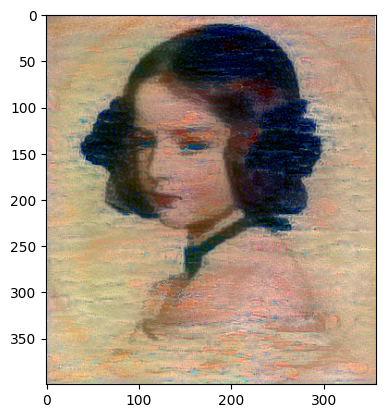

In [991]:
# save current generated image
imgx = deprocess_image(best_img.copy())
plt.imshow(imgx)

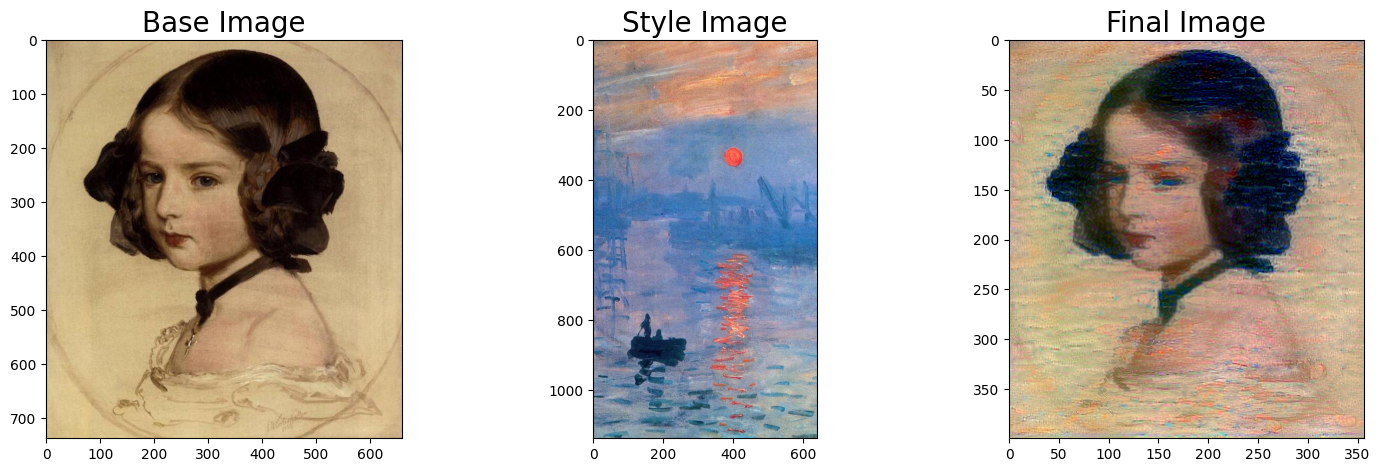

In [992]:
plt.figure(figsize=(30,30))
plt.subplot(5,5,1)
plt.title("Base Image",fontsize=20)
img_base = image_utils.load_img(base_image_path)
plt.imshow(img_base)

plt.subplot(5,5,1+1)
plt.title("Style Image",fontsize=20)
img_style = image_utils.load_img(style_image_path)
plt.imshow(img_style)

plt.subplot(5,5,1+2)
plt.title("Final Image",fontsize=20)
plt.imshow(imgx)